In [ ]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("/content/data1.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import glob
from PIL import Image

In [ ]:
filelist = glob.glob('/content/data1/*.jpg')
data = np.array([np.array(Image.open(fname)) for fname in filelist])

In [ ]:
import random as ra
def random_signal(s_l):
    signal = []
    for i in range(s_l):
        signal.append(ra.gauss(mu=0,sigma=1))
    return signal

In [ ]:
X_train, X_test, _, _ = train_test_split(data, data, test_size=0.33, random_state=42)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_noise=X_train
for i in range(len(X_noise)):
  X_noise[i]=X_noise[i]+np.array(random_signal(224*224*3)).reshape(224,224,3)
print(X_train.shape)

(1500, 224, 224, 3)


In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model

# The encoding process
input_img = Input(shape=(224, 224, 3))  

############
# Encoding #
############

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = x


In [ ]:
############
# Decoding #
############
x = Conv2DTranspose(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464 

In [ ]:
# Train the model
autoencoder.fit(X_noise, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test)
               )

Epoch 1/50
12/12 [==============================] - 26s 1s/step - loss: 1.0583 - val_loss: 0.0609
Epoch 2/50
12/12 [==============================] - 10s 853ms/step - loss: 1.0439 - val_loss: 0.0613
Epoch 3/50
12/12 [==============================] - 10s 852ms/step - loss: 1.0359 - val_loss: 0.0617
Epoch 4/50
12/12 [==============================] - 10s 856ms/step - loss: 1.0329 - val_loss: 0.0622
Epoch 5/50
12/12 [==============================] - 10s 859ms/step - loss: 1.0308 - val_loss: 0.0634
Epoch 6/50
12/12 [==============================] - 10s 863ms/step - loss: 1.0290 - val_loss: 0.0656
Epoch 7/50
12/12 [==============================] - 10s 871ms/step - loss: 1.0262 - val_loss: 0.0736
Epoch 8/50
12/12 [==============================] - 10s 867ms/step - loss: 1.0207 - val_loss: 0.1344
Epoch 9/50
12/12 [==============================] - 10s 867ms/step - loss: 1.0185 - val_loss: 0.1836
Epoch 10/50
12/12 [==============================] - 10s 859ms/step - loss: 1.0172 - val_loss:

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

24/24 [==============================] - 3s 77ms/step


In [ ]:
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(X_test)
print(encoded_images.shape)

24/24 [==============================] - 1s 43ms/step
(739, 14, 14, 128)


In [ ]:
encoded_input = Input(shape=(14,14,128))

x = Conv2DTranspose(128, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded_input)
x = Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
last = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, last)
decoder.compile(optimizer='adam', loss='binary_crossentropy')
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 128)]     0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 56, 56, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 112, 112, 32)     18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 224, 224, 16)     4624      
 Transpose)                                                

In [ ]:
k = 0
for i in range (10,20):
    decoder.weights[k].assign(autoencoder.weights[i])
    k = k+1

In [ ]:
decoded_images = decoder.predict(encoded_images)

24/24 [==============================] - 1s 24ms/step


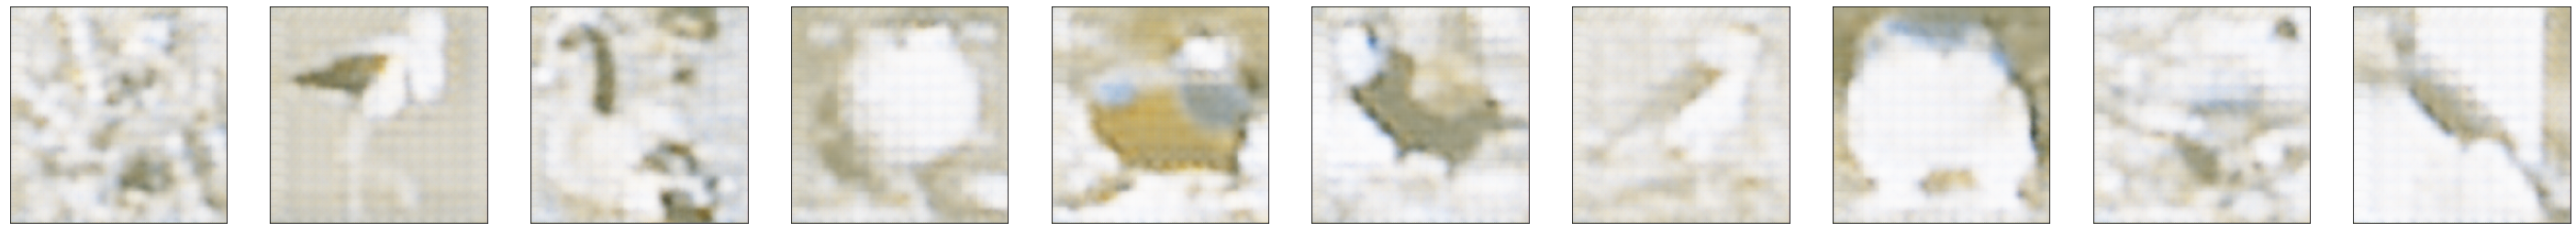

In [ ]:
import matplotlib.pyplot as plt

n = 10 # how many records we will display
plt.figure(figsize=(50, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(224,224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

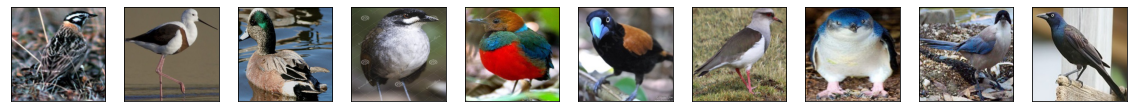

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many records we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

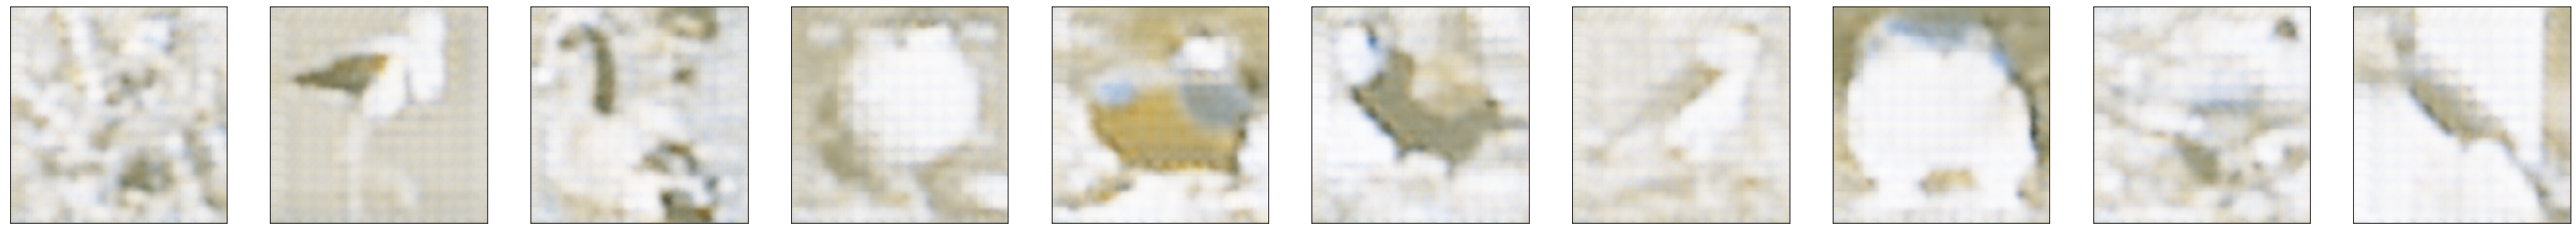

In [ ]:
import matplotlib.pyplot as plt

n = 10 # how many records we will display
plt.figure(figsize=(50, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_images[i].reshape(224,224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
autoencoder.save("/content/Untitled Folder")

In [ ]:
encoded_noise=encoder.predict(X_test)
for i in range(len(encoded_noise)):
  encoded_noise[i]=encoded_noise[i]+np.array(random_signal(14*14*128)).reshape(14, 14, 128)
print(encoded_noise.shape)

24/24 [==============================] - 1s 44ms/step
(739, 14, 14, 128)


In [ ]:
decoded_noise = decoder.predict(encoded_noise)

24/24 [==============================] - 1s 24ms/step


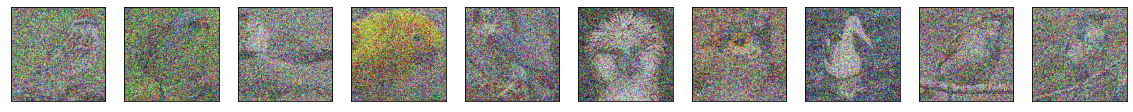

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many records we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_noise[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
import matplotlib.pyplot as plt

n = 10 # how many records we will display
plt.figure(figsize=(50, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_noise[i].reshape(224,224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

(224, 64)
(224, 224)


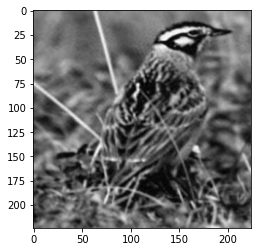

In [ ]:
from sklearn.decomposition import PCA

image=X_test[0]
image=np.mean(image,axis=2)
plt.imshow(image)
plt.show()
pca_com=64

pca_im=PCA(n_components=pca_com)
re_im=pca_im.fit_transform(image)
print(re_im.shape)


rec_im=pca_im.inverse_transform(re_im)
print(rec_im.shape)

plt.imshow(rec_im)
plt.show()